In [1]:
%pip install numpy pandas tensorflow matplotlib scikit-learn keras statsmodels keras_tuner optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score

In [3]:
# Cargar los datos
data = pd.read_csv('datos_limpios0.csv')
data = data[data['department'] == 'sweing']
data.drop(columns=['department'], inplace=True)
data.shape

(666, 14)

**Factores:**
- **Date**: Date in MM-DD-YYYY
- **Quarter**: A portion of the month. A month was divided into four quarters
- **Department**: Associated department with the instance
- **Day**: Day of the Week
- **Team**: Associated team number with the instance
- **Targeted productivity**: Targeted productivity set by the Authority for each team for each day.
- **SMV**: Standard Minute Value, it is the allocated time for a task
- **WIP**: Work in progress. Includes the number of unfinished items for products
- **Over time**: Represents the amount of overtime by each team in minutes
- **Incentive**: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- **Idle time**: The amount of time when the production was interrupted due to several reasons
- **Idle men**: The number of workers who were idle due to production interruption
- **No of style change**: Number of changes in the style of a particular product
- **No of workers**: Number of workers in each team

**Variable de respuesta:**
- **Actual productivity**: The actual % of productivity that was delivered by the workers. It ranges from 0-1.



In [4]:
# Convertir la columna 'Date' a tipo datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extraer día, mes y año de la columna 'Date'
data['Day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['Year'] = data['date'].dt.year

# Eliminar la columna 'Date'
data.drop(columns=['date'], inplace=True)

# Mostrar las primeras filas del DataFrame
data.head()

,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Day,Month,Year
0,Quarter1,Thursday,8,0.8,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,1,2015
2,Quarter1,Thursday,11,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
3,Quarter1,Thursday,12,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
4,Quarter1,Thursday,6,0.8,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,1,2015
5,Quarter1,Thursday,7,0.8,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125,1,1,2015


In [5]:
# Realizo una copia del DataFrame original
data_encoded = data.copy()

# Codificar las columnas categóricas en la copia
data_encoded['quarter'] = data_encoded['quarter'].astype('category').cat.codes
data_encoded['day'] = data_encoded['day'].astype('category').cat.codes
data_encoded['team'] = data_encoded['team'].astype('category').cat.codes

In [6]:
data_encoded.columns.tolist()

['quarter',
 'day',
 'team',
 'targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers',
 'actual_productivity',
 'Day',
 'Month',
 'Year']

Del modelo lineal total se encontraron que las siguientes variables eran significativas, por lo que se decidio que estas fueran las escogidas para la red neuronal

In [7]:
features = ['targeted_productivity', 'smv', 'idle_men', 'no_of_workers', 'team', 'quarter']

X = data_encoded[features]

X = pd.get_dummies(X, columns=['team', 'quarter'], dtype=int, drop_first=True)
X.head()


,targeted_productivity,smv,idle_men,no_of_workers,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4
0,0.8,26.16,0,59.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.8,11.41,0,30.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.8,11.41,0,30.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.8,25.90,0,56.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0.8,25.90,0,56.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [8]:
features_Y = ['quarter', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

X_more = data_encoded[features_Y]
X_more = pd.get_dummies(X_more, columns=['day', 'team', 'quarter'], dtype=int, drop_first=True)


In [9]:
X_more.shape

(666, 30)

Se emplean las variables significativas encontradas en el modelo lineal

In [10]:
# Definir las características significativas
significant_features = [
    'targeted_productivity', 'smv', 'incentive', 'idle_men', 'no_of_workers',
    'team_10','actual_productivity']

# Filtrar solo las características significativas
X_more = X_more[significant_features]

# Mostrar las primeras filas del DataFrame resultante
X_more.head()

,targeted_productivity,smv,incentive,idle_men,no_of_workers,team_10,actual_productivity
0,0.8,26.16,98,0,59.0,0,0.940725
2,0.8,11.41,50,0,30.5,1,0.800570
3,0.8,11.41,50,0,30.5,0,0.800570
4,0.8,25.90,50,0,56.0,0,0.800382
5,0.8,25.90,38,0,56.0,0,0.800125


In [11]:
Y = data_encoded["actual_productivity"]

Y.head()

0    0.940725
2    0.800570
3    0.800570
4    0.800382
5    0.800125
Name: actual_productivity, dtype: float64

In [12]:
train = X_more.sample(frac=0.8, random_state=100)
train.head()

,targeted_productivity,smv,incentive,idle_men,no_of_workers,team_10,actual_productivity
795,0.75,18.79,34,0,33.0,0,0.750651
1149,0.75,16.10,45,0,45.0,0,0.750141
1098,0.80,30.10,50,0,58.0,0,0.800842
396,0.75,22.52,94,0,57.0,0,0.900321
183,0.80,28.08,38,0,58.5,0,0.800000


In [13]:
test = X_more.drop(train.index)
test.head()

,targeted_productivity,smv,incentive,idle_men,no_of_workers,team_10,actual_productivity
0,0.8,26.16,98,0,59.0,0,0.940725
3,0.8,11.41,50,0,30.5,0,0.800570
5,0.8,25.90,38,0,56.0,0,0.800125
25,0.8,28.08,50,0,54.5,0,0.800323
26,0.8,26.16,50,0,59.0,0,0.800319


In [14]:
print(train.shape)
print(test.shape)

(533, 7)
(133, 7)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable continua

In [15]:
train.describe()

,targeted_productivity,smv,incentive,idle_men,no_of_workers,team_10,actual_productivity
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,0.721707,23.158124,42.559099,0.679174,52.294559,0.095685,0.713103
std,0.102238,7.079785,24.430175,4.442223,9.555659,0.294435,0.147172
min,0.070000,10.050000,0.000000,0.000000,26.000000,0.000000,0.233705
25%,0.700000,18.790000,30.000000,0.000000,52.000000,0.000000,0.650421
50%,0.750000,22.520000,45.000000,0.000000,57.000000,0.000000,0.750474
75%,0.800000,28.080000,60.000000,0.000000,58.000000,0.000000,0.800402
max,0.800000,51.020000,113.000000,45.000000,89.000000,1.000000,0.999995


Seleccionamos ahora las características y las etiquetas (MPG)

In [16]:
X_train = train.copy()
X_test = test.copy()

In [17]:
y_train = X_train.pop('actual_productivity')
y_test = X_test.pop('actual_productivity')

In [18]:
X_train.head()

,targeted_productivity,smv,incentive,idle_men,no_of_workers,team_10
795,0.75,18.79,34,0,33.0,0
1149,0.75,16.10,45,0,45.0,0
1098,0.80,30.10,50,0,58.0,0
396,0.75,22.52,94,0,57.0,0
183,0.80,28.08,38,0,58.5,0


In [19]:
y_train.head()

795     0.750651
1149    0.750141
1098    0.800842
396     0.900321
183     0.800000
Name: actual_productivity, dtype: float64

In [20]:
#from sklearn import metrics
#import statsmodels.api as sm
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.2)


## Normalizacion

In [21]:
tf.keras.layers.Normalization
norm = tf.keras.layers.Normalization()

In [22]:
norm.adapt(np.array(X_train))

In [23]:
norm.mean.numpy()

array([[ 0.72170734, 23.158123  , 42.5591    ,  0.6791745 , 52.29456   ,
         0.0956848 ]], dtype=float32)

In [24]:
norm.variance.numpy()

array([[1.0432920e-02, 5.0029316e+01, 5.9571368e+02, 1.9696320e+01,
        9.1139313e+01, 8.6529225e-02]], dtype=float32)

## Modelo lineal

In [25]:
#Importar las librerias necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import r2_score


/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/1314391556.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [26]:
class LinearHyperModel(HyperModel):
    def build(self, hp):
        # Crear un modelo secuencial
        model = tf.keras.Sequential([
            norm,  # Capa de normalización para los datos de entrada
            tf.keras.layers.Dense(units=1)  # Capa de salida con una unidad
        ])
        # Compilar el modelo
        model.compile(
            # Optimizer Adam con tasa de aprendizaje ajustable (Se va a intentar encontrar cual es la mejor tasa de aprendizaje)
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
            # Función de pérdida ajustable (MAE o MSE)
            loss=hp.Choice('loss', ['mean_absolute_error', 'mean_squared_error'])
        )
        return model


In [27]:
tuner = BayesianOptimization(
    LinearHyperModel(),
    objective='val_loss',  # Usamos val_loss como objetivo durante la búsqueda
    max_trials=10,
    directory='Modelo neuronal lineal',
    project_name='linear_optimization',
    executions_per_trial=1
)

Reloading Tuner from Modelo neuronal lineal/linear_optimization/tuner0.json


In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
# Normalizar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar el modelo utilizando el tuner con los datos escalados
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2)

# Guardar los resultados del modelo de la mejor configuración
bestLinearModel = tuner.get_best_models(num_models=1)[0]
bestLinearHyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Se guarda la mejor learning rate y loss function
bestLearningRate = bestLinearHyperparameters.get('learning_rate')
bestLossFunction = bestLinearHyperparameters.get('loss')

# Se evalúa el modelo con el conjunto de prueba escalado
test_loss = bestLinearModel.evaluate(X_test_scaled, y_test, verbose=0)

# Para encontrar el R^2 se utiliza la función r2_score de sklearn
yLinearPred = bestLinearModel.predict(X_test_scaled)
r2 = r2_score(y_test, yLinearPred)

# Guardar los resultados del optimizador en un diccionario
resultadosOptimizador = {
    'learningRate': bestLearningRate,
    'lossFunction': bestLossFunction,
    'testLoss': test_loss,
    'r2': r2
}


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/stepp

/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [30]:
# Imprimir los resultados de forma bonita
print("Resultados del Optimizador:")
print(f"  - Tasa de aprendizaje: {resultadosOptimizador['learningRate']:.5f}")
print(f"  - Función de pérdida: {resultadosOptimizador['lossFunction']}")
print(f"  - Pérdida en el conjunto de prueba: {resultadosOptimizador['testLoss']:.4f}")
print(f"  - R² del modelo: {resultadosOptimizador['r2']:.4f}")

Resultados del Optimizador:
  - Tasa de aprendizaje: 0.10000
  - Función de pérdida: mean_squared_error
  - Pérdida en el conjunto de prueba: 0.0123
  - R² del modelo: 0.4333


In [31]:
linear_model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(units=1)
])

In [32]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=resultadosOptimizador['learningRate']),
    loss=resultadosOptimizador['lossFunction'])

In [33]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0655 - val_loss: 0.2528
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1493 - val_loss: 0.0556
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0419 - val_loss: 0.0235
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - val_loss: 0.0112
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0128
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041 - val_loss: 0.0085
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_lo

In [34]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (152.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 13 (56.00 B)

 Optimizer params: 16 (68.00 B)

In [35]:
import matplotlib.pyplot as plt

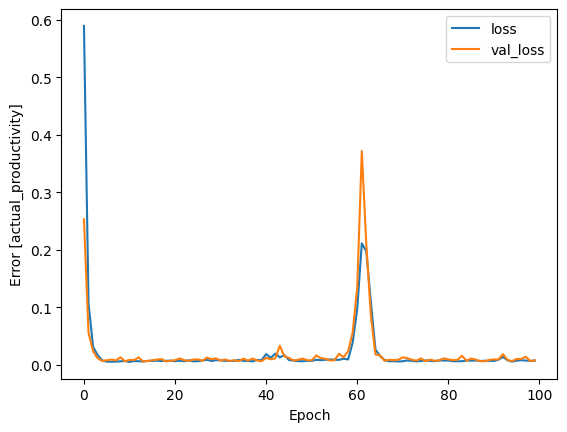

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [37]:
test_res = {}
test_res['linear_model'] = linear_model.evaluate(
    X_test,
    y_test, verbose=0)

In [38]:
test_res

{'linear_model': 0.006190678104758263}

## DNN

In [39]:
#Nueva libreria
import optuna

/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import optuna
import tensorflow as tf
from sklearn.metrics import r2_score

# Definir la función para construir el modelo
def build_model(trial, input_shape):
    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 6)  # Número de capas ocultas
    units_per_layer = [trial.suggest_int(f'units_{i}', 16, 256) for i in range(num_layers)]  # Unidades en cada capa
    activation_function = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])  # Función de activación
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje

    # Crear el modelo secuencial
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Añadir las capas ocultas
    for units in units_per_layer:
        model.add(tf.keras.layers.Dense(units, activation=activation_function))

    # Añadir la capa de salida
    model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )

    return model

# Definir la función para entrenar el modelo
def train_model(model, X_train, y_train):
    # Entrenar el modelo
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
    )
    return history

# Definir la función para evaluar el modelo
def evaluate_model(model, X_train, y_train):
    # Hacer predicciones en el conjunto de validación
    val_predictions = model.predict(X_train)

    # Calcular el R^2
    r2 = r2_score(y_train, val_predictions)

    return r2

# Definir la función objetivo para la optimización
def objective(trial):
    # Construir el modelo
    model = build_model(trial, input_shape=(X_train.shape[1],))

    # Entrenar el modelo
    train_model(model, X_train, y_train)

    # Evaluar el modelo
    r2 = evaluate_model(model, X_train, y_train)

    return r2

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-10-17 10:23:23,595] A new study created in memory with name: no-name-340ed326-ae90-480d-a3ca-3eaf034814db
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:23:27,721] Trial 0 finished with value: 0.6123364721160685 and parameters: {'num_layers': 3, 'units_0': 67, 'units_1': 59, 'units_2': 225, 'activation': 'tanh', 'learning_rate': 0.0008827767487538395}. Best is trial 0 with value: 0.6123364721160685.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-10-17 10:23:35,303] Trial 1 finished with value: 0.39790410682337685 and parameters: {'num_layers': 6, 'units_0': 252, 'units_1': 133, 'units_2': 243, 'units_3': 206, 'units_4': 219, 'units_5': 227, 'activation': 'relu', 'learning_rate': 1.2398923838539023e-05}. Best is trial 0 with value: 0.6123364721160685.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:23:38,513] Trial 2 finished with value: 0.6224115564313653 and parameters: {'num_layers': 2, 'units_0': 24, 'units_1': 231, 'activation': 'sigmoid', 'learning_rate': 0.00017176896137361845}. Best is trial 2 with value: 0.6224115564313653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:23:43,283] Trial 3 finished with value: 0.6134805414971646 and parameters: {'num_layers': 5, 'units_0': 150, 'units_1': 106, 'units_2': 158, 'units_3': 117, 'units_4': 164, 'activation': 'tanh', 'learning_rate': 0.004205482899159602}. Best is trial 2 with value: 0.6224115564313653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:23:46,747] Trial 4 finished with value: -42.32120275002871 and parameters: {'num_layers': 2, 'units_0': 209, 'units_1': 177, 'activation': 'sigmoid', 'learning_rate': 0.0782335926500989}. Best is trial 2 with value: 0.6224115564313653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:23:51,220] Trial 5 finished with value: 0.6816729463585876 and parameters: {'num_layers': 6, 'units_0': 224, 'units_1': 53, 'units_2': 21, 'units_3': 106, 'units_4': 241, 'units_5': 72, 'activation': 'sigmoid', 'learning_rate': 0.007236531940148155}. Best is trial 5 with value: 0.6816729463585876.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:23:55,268] Trial 6 finished with value: 0.62712249361045 and parameters: {'num_layers': 4, 'units_0': 76, 'units_1': 219, 'units_2': 152, 'units_3': 17, 'activation': 'relu', 'learning_rate': 0.0010683510934444103}. Best is trial 5 with value: 0.6816729463585876.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-10-17 10:23:59,866] Trial 7 finished with value: 0.59625336619229 and parameters: {'num_layers': 6, 'units_0': 36, 'units_1': 144, 'units_2': 55, 'units_3': 113, 'units_4': 85, 'units_5': 64, 'activation': 'tanh', 'learning_rate': 1.6787743782220215e-05}. Best is trial 5 with value: 0.6816729463585876.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-10-17 10:24:04,765] Trial 8 finished with value: 0.6137930400301446 and parameters: {'num_layers': 5, 'units_0': 215, 'units_1': 131, 'units_2': 159, 'units_3': 78, 'units_4': 231, 'activation': 'sigmoid', 'learning_rate': 0.0072544771238796}. Best is trial 5 with value: 0.6816729463585876.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:24:10,264] Trial 9 finished with value: -0.5221291776311539 and parameters: {'num_layers': 6, 'units_0': 158, 'units_1': 27, 'units_2': 136, 'units_3': 201, 'units_4': 250, 'units_5': 93, 'activation': 'sigmoid', 'learning_rate': 0.040505935523865694}. Best is trial 5 with value: 0.6816729463585876.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:24:19,287] Trial 10 finished with value: 0.694061205313973 and parameters: {'num_layers': 1, 'units_0': 193, 'activation': 'sigmoid', 'learning_rate': 0.008987366323663417}. Best is trial 10 with value: 0.694061205313973.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:24:22,856] Trial 11 finished with value: 0.44751707176144784 and parameters: {'num_layers': 1, 'units_0': 197, 'activation': 'sigmoid', 'learning_rate': 0.01246661157131179}. Best is trial 10 with value: 0.694061205313973.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:24:25,988] Trial 12 finished with value: 0.658474480846039 and parameters: {'num_layers': 1, 'units_0': 245, 'activation': 'sigmoid', 'learning_rate': 0.0015641607409537818}. Best is trial 10 with value: 0.694061205313973.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:24:30,808] Trial 13 finished with value: 0.5596169112859272 and parameters: {'num_layers': 3, 'units_0': 173, 'units_1': 73, 'units_2': 20, 'activation': 'sigmoid', 'learning_rate': 0.020850734343864}. Best is trial 10 with value: 0.694061205313973.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:24:35,419] Trial 14 finished with value: 0.6471780254032157 and parameters: {'num_layers': 4, 'units_0': 127, 'units_1': 26, 'units_2': 84, 'units_3': 35, 'activation': 'sigmoid', 'learning_rate': 0.0001806220621265929}. Best is trial 10 with value: 0.694061205313973.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:24:40,619] Trial 15 finished with value: 0.7059153573299501 and parameters: {'num_layers': 2, 'units_0': 121, 'units_1': 76, 'activation': 'relu', 'learning_rate': 0.006023271877262618}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:24:44,483] Trial 16 finished with value: 0.6599487739086882 and parameters: {'num_layers': 2, 'units_0': 119, 'units_1': 187, 'activation': 'relu', 'learning_rate': 0.0024221897270254285}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


[I 2024-10-17 10:24:47,893] Trial 17 finished with value: 0.39960942624165896 and parameters: {'num_layers': 1, 'units_0': 105, 'activation': 'relu', 'learning_rate': 0.0002648383024751903}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:24:52,896] Trial 18 finished with value: 0.6581012634710426 and parameters: {'num_layers': 2, 'units_0': 181, 'units_1': 91, 'activation': 'relu', 'learning_rate': 0.022956585603335296}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:24:57,077] Trial 19 finished with value: -0.0489971112791765 and parameters: {'num_layers': 1, 'units_0': 94, 'activation': 'relu', 'learning_rate': 0.06198947488516875}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:25:02,545] Trial 20 finished with value: 0.20866556069625264 and parameters: {'num_layers': 3, 'units_0': 148, 'units_1': 253, 'units_2': 204, 'activation': 'relu', 'learning_rate': 0.0006282185695820893}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:25:07,651] Trial 21 finished with value: 0.6665795338497299 and parameters: {'num_layers': 5, 'units_0': 225, 'units_1': 54, 'units_2': 101, 'units_3': 256, 'units_4': 17, 'activation': 'sigmoid', 'learning_rate': 0.004577574593684265}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:25:12,357] Trial 22 finished with value: 0.6850292497904247 and parameters: {'num_layers': 2, 'units_0': 185, 'units_1': 100, 'activation': 'sigmoid', 'learning_rate': 0.010342441049637538}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:25:18,938] Trial 23 finished with value: 0.4725708236931184 and parameters: {'num_layers': 2, 'units_0': 182, 'units_1': 101, 'activation': 'tanh', 'learning_rate': 0.01458229800759249}. Best is trial 15 with value: 0.7059153573299501.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:25:22,070] Trial 24 finished with value: 0.7103609937982716 and parameters: {'num_layers': 1, 'units_0': 166, 'activation': 'sigmoid', 'learning_rate': 0.002495400516436302}. Best is trial 24 with value: 0.7103609937982716.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:25:25,102] Trial 25 finished with value: 0.45416407246527557 and parameters: {'num_layers': 1, 'units_0': 138, 'activation': 'relu', 'learning_rate': 0.002845105057952143}. Best is trial 24 with value: 0.7103609937982716.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:25:28,295] Trial 26 finished with value: 0.719677147255642 and parameters: {'num_layers': 1, 'units_0': 164, 'activation': 'sigmoid', 'learning_rate': 0.0005710929477167736}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:25:32,328] Trial 27 finished with value: 0.6470521765715445 and parameters: {'num_layers': 1, 'units_0': 164, 'activation': 'sigmoid', 'learning_rate': 5.7591915725563734e-05}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:25:35,947] Trial 28 finished with value: 0.6871978563842995 and parameters: {'num_layers': 2, 'units_0': 105, 'units_1': 163, 'activation': 'tanh', 'learning_rate': 0.0005187770561332702}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:25:40,183] Trial 29 finished with value: 0.7189657557627204 and parameters: {'num_layers': 3, 'units_0': 63, 'units_1': 201, 'units_2': 203, 'activation': 'relu', 'learning_rate': 0.001511512060136908}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:25:44,110] Trial 30 finished with value: 0.6275309621143057 and parameters: {'num_layers': 3, 'units_0': 52, 'units_1': 211, 'units_2': 193, 'activation': 'tanh', 'learning_rate': 0.0003882144507067677}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:25:48,473] Trial 31 finished with value: 0.6558364073694902 and parameters: {'num_layers': 3, 'units_0': 80, 'units_1': 203, 'units_2': 252, 'activation': 'relu', 'learning_rate': 0.001354951240612822}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:25:52,123] Trial 32 finished with value: 0.5078250391671856 and parameters: {'num_layers': 2, 'units_0': 53, 'units_1': 247, 'activation': 'relu', 'learning_rate': 0.002448723756639719}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:25:56,701] Trial 33 finished with value: 0.7061893394955283 and parameters: {'num_layers': 4, 'units_0': 135, 'units_1': 169, 'units_2': 186, 'units_3': 180, 'activation': 'relu', 'learning_rate': 0.0008597356992661911}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:26:01,164] Trial 34 finished with value: 0.5339117176383914 and parameters: {'num_layers': 4, 'units_0': 144, 'units_1': 155, 'units_2': 184, 'units_3': 169, 'activation': 'relu', 'learning_rate': 8.830962213895903e-05}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:26:06,195] Trial 35 finished with value: 0.7104938090827637 and parameters: {'num_layers': 4, 'units_0': 17, 'units_1': 181, 'units_2': 213, 'units_3': 256, 'activation': 'relu', 'learning_rate': 0.0007472502273356068}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2024-10-17 10:26:12,279] Trial 36 finished with value: 0.6295422325992175 and parameters: {'num_layers': 5, 'units_0': 20, 'units_1': 198, 'units_2': 224, 'units_3': 225, 'units_4': 88, 'activation': 'sigmoid', 'learning_rate': 0.0003076280787664162}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:26:18,590] Trial 37 finished with value: 0.4877531511622277 and parameters: {'num_layers': 3, 'units_0': 58, 'units_1': 230, 'units_2': 122, 'activation': 'relu', 'learning_rate': 0.00010558750944848373}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:26:24,361] Trial 38 finished with value: 0.6439850803334972 and parameters: {'num_layers': 4, 'units_0': 34, 'units_1': 187, 'units_2': 219, 'units_3': 246, 'activation': 'sigmoid', 'learning_rate': 0.0007707542683671621}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:26:30,152] Trial 39 finished with value: 0.708466652035559 and parameters: {'num_layers': 5, 'units_0': 35, 'units_1': 117, 'units_2': 178, 'units_3': 149, 'units_4': 17, 'activation': 'tanh', 'learning_rate': 0.0015805412749699543}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:26:34,756] Trial 40 finished with value: 0.6089832615333216 and parameters: {'num_layers': 4, 'units_0': 66, 'units_1': 148, 'units_2': 210, 'units_3': 74, 'activation': 'relu', 'learning_rate': 0.0033572858278809216}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:26:39,619] Trial 41 finished with value: 0.6632668857253616 and parameters: {'num_layers': 5, 'units_0': 33, 'units_1': 130, 'units_2': 174, 'units_3': 165, 'units_4': 16, 'activation': 'tanh', 'learning_rate': 0.0016256635427774468}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-10-17 10:26:44,514] Trial 42 finished with value: 0.6704852380372044 and parameters: {'num_layers': 5, 'units_0': 39, 'units_1': 128, 'units_2': 236, 'units_3': 159, 'units_4': 82, 'activation': 'tanh', 'learning_rate': 0.0011916958743097364}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:26:49,808] Trial 43 finished with value: 0.6315147547377354 and parameters: {'num_layers': 6, 'units_0': 21, 'units_1': 185, 'units_2': 172, 'units_3': 140, 'units_4': 151, 'units_5': 202, 'activation': 'tanh', 'learning_rate': 0.00047874525062177196}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:26:54,910] Trial 44 finished with value: 0.7081567683601975 and parameters: {'num_layers': 5, 'units_0': 16, 'units_1': 228, 'units_2': 202, 'units_3': 227, 'units_4': 44, 'activation': 'tanh', 'learning_rate': 0.0019606869915384196}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:26:59,554] Trial 45 finished with value: 0.6487747680930389 and parameters: {'num_layers': 4, 'units_0': 44, 'units_1': 117, 'units_2': 139, 'units_3': 75, 'activation': 'sigmoid', 'learning_rate': 0.004511534919417802}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:27:04,616] Trial 46 finished with value: 0.6896792485583194 and parameters: {'num_layers': 6, 'units_0': 163, 'units_1': 171, 'units_2': 116, 'units_3': 189, 'units_4': 186, 'units_5': 16, 'activation': 'tanh', 'learning_rate': 0.0009008772077830675}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:27:07,832] Trial 47 finished with value: 0.6393797646027117 and parameters: {'num_layers': 1, 'units_0': 76, 'activation': 'sigmoid', 'learning_rate': 0.00024854541684250883}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:27:14,157] Trial 48 finished with value: 0.5058118535996672 and parameters: {'num_layers': 5, 'units_0': 203, 'units_1': 119, 'units_2': 236, 'units_3': 136, 'units_4': 124, 'activation': 'sigmoid', 'learning_rate': 0.0011927010109454724}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:27:19,079] Trial 49 finished with value: 0.6419980396956109 and parameters: {'num_layers': 3, 'units_0': 30, 'units_1': 156, 'units_2': 222, 'activation': 'tanh', 'learning_rate': 0.00015423505686086204}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


[I 2024-10-17 10:27:23,829] Trial 50 finished with value: -0.19589555843357997 and parameters: {'num_layers': 1, 'units_0': 44, 'activation': 'sigmoid', 'learning_rate': 3.494241061471102e-05}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:27:28,729] Trial 51 finished with value: 0.5788779043448009 and parameters: {'num_layers': 5, 'units_0': 16, 'units_1': 237, 'units_2': 193, 'units_3': 232, 'units_4': 54, 'activation': 'tanh', 'learning_rate': 0.001964618791808404}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:27:33,649] Trial 52 finished with value: 0.6478077185423766 and parameters: {'num_layers': 5, 'units_0': 63, 'units_1': 217, 'units_2': 204, 'units_3': 214, 'units_4': 46, 'activation': 'tanh', 'learning_rate': 0.0018968454657950651}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:27:39,825] Trial 53 finished with value: 0.6997170246030772 and parameters: {'num_layers': 6, 'units_0': 25, 'units_1': 230, 'units_2': 173, 'units_3': 238, 'units_4': 51, 'units_5': 159, 'activation': 'tanh', 'learning_rate': 0.0006215551414972146}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-10-17 10:27:49,286] Trial 54 finished with value: 0.5412418609739089 and parameters: {'num_layers': 4, 'units_0': 16, 'units_1': 195, 'units_2': 208, 'units_3': 254, 'activation': 'tanh', 'learning_rate': 0.006002709332004499}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-10-17 10:27:55,961] Trial 55 finished with value: 0.6903377783927824 and parameters: {'num_layers': 5, 'units_0': 158, 'units_1': 211, 'units_2': 255, 'units_3': 216, 'units_4': 117, 'activation': 'relu', 'learning_rate': 0.00337778482173589}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:28:03,893] Trial 56 finished with value: 0.6810784190912553 and parameters: {'num_layers': 6, 'units_0': 46, 'units_1': 179, 'units_2': 155, 'units_3': 188, 'units_4': 35, 'units_5': 255, 'activation': 'tanh', 'learning_rate': 0.0003801988456661827}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 10:28:07,891] Trial 57 finished with value: 0.6650973405576528 and parameters: {'num_layers': 4, 'units_0': 28, 'units_1': 139, 'units_2': 165, 'units_3': 203, 'activation': 'sigmoid', 'learning_rate': 0.0020387492365978727}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 10:28:13,627] Trial 58 finished with value: 0.6353353646134208 and parameters: {'num_layers': 5, 'units_0': 175, 'units_1': 239, 'units_2': 236, 'units_3': 144, 'units_4': 74, 'activation': 'relu', 'learning_rate': 0.0008597427840176614}. Best is trial 26 with value: 0.719677147255642.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:28:16,690] Trial 59 finished with value: 0.7286739210514522 and parameters: {'num_layers': 1, 'units_0': 90, 'activation': 'sigmoid', 'learning_rate': 0.0012619527217014725}. Best is trial 59 with value: 0.7286739210514522.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:28:19,925] Trial 60 finished with value: 0.6533641036327993 and parameters: {'num_layers': 1, 'units_0': 86, 'activation': 'sigmoid', 'learning_rate': 0.0006262055447886439}. Best is trial 59 with value: 0.7286739210514522.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


[I 2024-10-17 10:28:23,031] Trial 61 finished with value: 0.6767903151259738 and parameters: {'num_layers': 1, 'units_0': 71, 'activation': 'sigmoid', 'learning_rate': 0.00141682869237818}. Best is trial 59 with value: 0.7286739210514522.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:28:27,252] Trial 62 finished with value: 0.7141895296305996 and parameters: {'num_layers': 1, 'units_0': 103, 'activation': 'sigmoid', 'learning_rate': 0.0032001685981936897}. Best is trial 59 with value: 0.7286739210514522.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:28:30,474] Trial 63 finished with value: 0.7223760172463715 and parameters: {'num_layers': 1, 'units_0': 91, 'activation': 'sigmoid', 'learning_rate': 0.0035115287650791995}. Best is trial 59 with value: 0.7286739210514522.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


[I 2024-10-17 10:28:33,947] Trial 64 finished with value: 0.7301013689057652 and parameters: {'num_layers': 1, 'units_0': 105, 'activation': 'sigmoid', 'learning_rate': 0.007095704797376573}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:28:37,141] Trial 65 finished with value: 0.6859237027872875 and parameters: {'num_layers': 1, 'units_0': 107, 'activation': 'sigmoid', 'learning_rate': 0.007159847280548125}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-10-17 10:28:40,260] Trial 66 finished with value: 0.5213692797309821 and parameters: {'num_layers': 1, 'units_0': 91, 'activation': 'sigmoid', 'learning_rate': 0.015948266504219516}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:28:43,579] Trial 67 finished with value: 0.5200145576613053 and parameters: {'num_layers': 2, 'units_0': 120, 'units_1': 71, 'activation': 'sigmoid', 'learning_rate': 0.005610114397770151}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:28:46,628] Trial 68 finished with value: 0.683195025566854 and parameters: {'num_layers': 1, 'units_0': 98, 'activation': 'sigmoid', 'learning_rate': 0.003559024336426852}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:28:50,161] Trial 69 finished with value: 0.664092090030918 and parameters: {'num_layers': 2, 'units_0': 109, 'units_1': 46, 'activation': 'sigmoid', 'learning_rate': 0.010780880363030862}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:28:53,184] Trial 70 finished with value: 0.5428421463264488 and parameters: {'num_layers': 1, 'units_0': 82, 'activation': 'sigmoid', 'learning_rate': 0.03091724698987704}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:28:56,397] Trial 71 finished with value: 0.6729011317147604 and parameters: {'num_layers': 1, 'units_0': 129, 'activation': 'sigmoid', 'learning_rate': 0.0026365242795318073}. Best is trial 64 with value: 0.7301013689057652.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


[I 2024-10-17 10:28:59,544] Trial 72 finished with value: 0.7331116384685898 and parameters: {'num_layers': 1, 'units_0': 101, 'activation': 'sigmoid', 'learning_rate': 0.00430322080692856}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:29:02,934] Trial 73 finished with value: 0.7300710278977265 and parameters: {'num_layers': 1, 'units_0': 99, 'activation': 'sigmoid', 'learning_rate': 0.004810289553247131}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:29:05,981] Trial 74 finished with value: 0.7182581791345031 and parameters: {'num_layers': 1, 'units_0': 98, 'activation': 'sigmoid', 'learning_rate': 0.007626590423011701}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:29:08,991] Trial 75 finished with value: 0.37831565085408314 and parameters: {'num_layers': 1, 'units_0': 115, 'activation': 'sigmoid', 'learning_rate': 0.007980368319651843}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:29:12,404] Trial 76 finished with value: 0.7327072942893329 and parameters: {'num_layers': 2, 'units_0': 97, 'units_1': 17, 'activation': 'sigmoid', 'learning_rate': 0.004430680292649057}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:29:15,780] Trial 77 finished with value: 0.691466816993498 and parameters: {'num_layers': 2, 'units_0': 91, 'units_1': 20, 'activation': 'sigmoid', 'learning_rate': 0.004893367067185899}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:29:19,160] Trial 78 finished with value: 0.6882577054819429 and parameters: {'num_layers': 2, 'units_0': 73, 'units_1': 89, 'activation': 'sigmoid', 'learning_rate': 0.0038230725941186755}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:29:22,354] Trial 79 finished with value: 0.5853802990686743 and parameters: {'num_layers': 2, 'units_0': 112, 'units_1': 44, 'activation': 'sigmoid', 'learning_rate': 0.018805967474261335}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


[I 2024-10-17 10:29:25,612] Trial 80 finished with value: 0.7039757589338772 and parameters: {'num_layers': 1, 'units_0': 125, 'activation': 'sigmoid', 'learning_rate': 0.010114609828211989}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


[I 2024-10-17 10:29:28,552] Trial 81 finished with value: 0.7259136016844367 and parameters: {'num_layers': 1, 'units_0': 96, 'activation': 'sigmoid', 'learning_rate': 0.005837407905565244}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 10:29:32,230] Trial 82 finished with value: 0.6533754598162782 and parameters: {'num_layers': 1, 'units_0': 86, 'activation': 'sigmoid', 'learning_rate': 0.012438254319619353}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:29:35,285] Trial 83 finished with value: 0.6573906610871001 and parameters: {'num_layers': 1, 'units_0': 99, 'activation': 'sigmoid', 'learning_rate': 0.004787567112846784}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


[I 2024-10-17 10:29:38,528] Trial 84 finished with value: 0.6092558056957982 and parameters: {'num_layers': 1, 'units_0': 83, 'activation': 'sigmoid', 'learning_rate': 0.005982267722850577}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:29:41,792] Trial 85 finished with value: 0.678343314184251 and parameters: {'num_layers': 2, 'units_0': 92, 'units_1': 33, 'activation': 'sigmoid', 'learning_rate': 0.0044541409402558945}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:29:44,923] Trial 86 finished with value: 0.7264640222891895 and parameters: {'num_layers': 1, 'units_0': 136, 'activation': 'sigmoid', 'learning_rate': 0.00103388171491718}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:29:47,974] Trial 87 finished with value: 0.7269863197324535 and parameters: {'num_layers': 1, 'units_0': 148, 'activation': 'sigmoid', 'learning_rate': 0.00106342147822304}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:29:52,213] Trial 88 finished with value: 0.7135508910125521 and parameters: {'num_layers': 1, 'units_0': 136, 'activation': 'sigmoid', 'learning_rate': 0.0009967731408106434}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:29:55,466] Trial 89 finished with value: 0.7299200068205227 and parameters: {'num_layers': 1, 'units_0': 149, 'activation': 'sigmoid', 'learning_rate': 0.0025991838068753445}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


[I 2024-10-17 10:29:58,828] Trial 90 finished with value: 0.7303587983239196 and parameters: {'num_layers': 1, 'units_0': 150, 'activation': 'sigmoid', 'learning_rate': 0.0026724301552618944}. Best is trial 72 with value: 0.7331116384685898.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:30:02,000] Trial 91 finished with value: 0.7420801361592045 and parameters: {'num_layers': 1, 'units_0': 144, 'activation': 'sigmoid', 'learning_rate': 0.0022835791860423937}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:30:05,444] Trial 92 finished with value: 0.7420174012823941 and parameters: {'num_layers': 1, 'units_0': 152, 'activation': 'sigmoid', 'learning_rate': 0.0023188037722186687}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:30:08,431] Trial 93 finished with value: 0.6999398379471098 and parameters: {'num_layers': 1, 'units_0': 152, 'activation': 'sigmoid', 'learning_rate': 0.0024132300875638214}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:30:11,724] Trial 94 finished with value: 0.7315352773723991 and parameters: {'num_layers': 1, 'units_0': 144, 'activation': 'sigmoid', 'learning_rate': 0.002837443418938648}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:30:15,009] Trial 95 finished with value: 0.6153058860283523 and parameters: {'num_layers': 1, 'units_0': 155, 'activation': 'sigmoid', 'learning_rate': 0.0020405485184993425}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:30:18,352] Trial 96 finished with value: 0.6736230808056077 and parameters: {'num_layers': 2, 'units_0': 129, 'units_1': 63, 'activation': 'sigmoid', 'learning_rate': 0.0028196529091427014}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 10:30:21,405] Trial 97 finished with value: 0.5419904742553916 and parameters: {'num_layers': 1, 'units_0': 143, 'activation': 'sigmoid', 'learning_rate': 0.0022514731100943854}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 10:30:24,681] Trial 98 finished with value: 0.5835508890032719 and parameters: {'num_layers': 1, 'units_0': 172, 'activation': 'sigmoid', 'learning_rate': 0.0016823577607115896}. Best is trial 91 with value: 0.7420801361592045.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_2958/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 10:30:28,131] Trial 99 finished with value: 0.582010707325842 and parameters: {'num_layers': 1, 'units_0': 145, 'activation': 'sigmoid', 'learning_rate': 0.004097092593989983}. Best is trial 91 with value: 0.7420801361592045.


In [57]:
# Supongamos que estos son los mejores hiperparámetros y el mejor R^2 obtenidos del estudio
best_params = study.best_params
best_r2 = study.best_value

# Imprimir los mejores hiperparámetros de manera legible
print("Mejores hiperparámetros:")
print(f"  - Número de capas ocultas: {best_params['num_layers']}")
for i in range(best_params['num_layers']):
    print(f"  - Unidades en la capa {i}: {best_params[f'units_{i}']}")
    print(f"  - Función de activación: {best_params['activation']}")
print(f"  - Tasa de aprendizaje: {best_params['learning_rate']:.8f}")
print(f"Mejor R^2: {best_r2:.6f}")
print(best_params)

Mejores hiperparámetros:
  - Número de capas ocultas: 1
  - Unidades en la capa 0: 144
  - Función de activación: sigmoid
  - Tasa de aprendizaje: 0.00228358
Mejor R^2: 0.742080
{'num_layers': 1, 'units_0': 144, 'activation': 'sigmoid', 'learning_rate': 0.0022835791860423937}


## Empleando los mejores hiperparametros

Modelo con multiples varaibles de entrada

In [58]:
dnn_model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(144, activation='sigmoid'),
      tf.keras.layers.Dense(1)
  ])

In [59]:
dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(best_params['learning_rate']))


In [60]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3157 - val_loss: 0.1267
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 - val_loss: 0.0696
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628 - val_loss: 0.0559
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0436 - val_loss: 0.0460
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - val_loss: 0.0535
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 - val_loss: 0.0499
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - val_loss: 0.0564
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473 - val_loss: 0.0825
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0536 - val_loss: 0.0570
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0518 - val_loss: 0.0528
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 - val_loss: 0.0573
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

In [61]:
dnn_model.summary()

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 144)            │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 1)              │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,474 (13.58 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 13 (56.00 B)

 Optimizer params: 2,308 (9.02 KB)

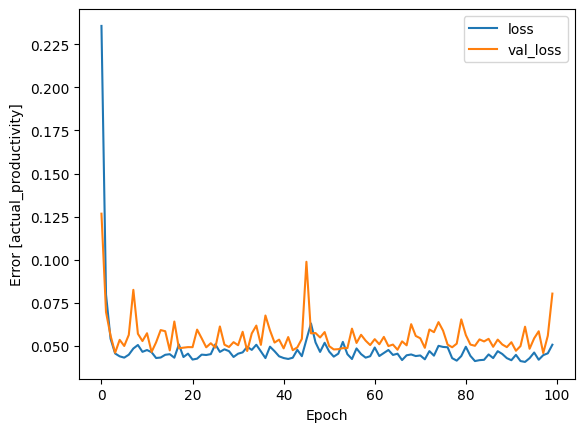

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [63]:
test_res['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [64]:
test_res

{'linear_model': 0.006190678104758263, 'dnn_model': 0.06886136531829834}

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


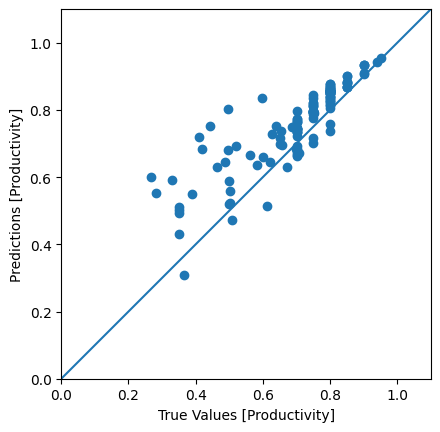

In [65]:
test_pred = dnn_model.predict(X_test).flatten()

plt.axes(aspect='equal')
plt.scatter(y_test, test_pred)
plt.xlabel('True Values [Productivity]')
plt.ylabel('Predictions [Productivity]')
lims = [0, 1.1]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

## Evaluacion de los modelos

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [67]:
#Prediccion del modelo lineal
linear_model_pred = linear_model.predict(X_test).flatten()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


In [68]:
# Calcular métricas para el modelo lineal
mae_ml = mean_absolute_error(y_test, linear_model_pred)
mse_ml = mean_squared_error(y_test, linear_model_pred)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(y_test, linear_model_pred)


In [69]:
#Evaluacion del modelo DNN
dnn_model_pred= dnn_model.predict(X_test).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [70]:
# Calcular métricas para el modelo DNN
mae_dnn = mean_absolute_error(y_test, dnn_model_pred)
mse_dnn = mean_squared_error(y_test, dnn_model_pred)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(y_test, dnn_model_pred)

In [71]:
# Create a DataFrame to compare the metrics of the models
metrics_comparison = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R^2 Score'],
    'Linear Model': [mae_ml, mse_ml, rmse_ml, r2_ml],
    'DNN Model': [mae_dnn, mse_dnn, rmse_dnn, r2_dnn]
})

# Print the DataFrame
print(metrics_comparison)

                           Metric  Linear Model  DNN Model
0       Mean Absolute Error (MAE)      0.056425   0.068861
1        Mean Squared Error (MSE)      0.006191   0.009044
2  Root Mean Squared Error (RMSE)      0.078681   0.095099
3                       R^2 Score      0.715343   0.584149
